<a href="https://colab.research.google.com/github/imtiaz114/Brain_tumor_detection_from_2D_MRI_images/blob/main/Brain_tumor_preprocessing_for_ML_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image preprocessing

Proposed Methodology:

1. Skull stripping
        Thresholding
        Connected Component Analysis
2. Filtering and Enhancement
3. Segmentation using Kmeans
4. Morphological Operations
5. Tumor Contouring

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from google.colab.patches import cv2_imshow
%matplotlib inline

## 1. Skull stripping

### Thresholding

In [ ]:
image_name = 'Y100'

image_directory_yes = '/content/drive/MyDrive/datasets/brain_tumor/brain_tumor_dataset_1/brain_tumor_dataset/yes_m' + '/'

#this img_file is the variable, changing it will set image name everywhere needed
img_file = image_directory_yes + image_name + '.jpg'

In [ ]:
# loading image
img = cv2.imread(img_file)
dim = (256,256)
image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
cv2_imshow(image)

In [ ]:
#normalizing image
image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
image = image.astype(np.uint8)

In [ ]:
#thresholding
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#thresh = cv2.threshold(gray, 0, 255,	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.adaptiveThreshold(gray, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,21,0)

### Connected component analysis

In [ ]:
#connected component analysis
connectivity = 8
output = cv2.connectedComponentsWithStats(
	thresh, connectivity, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output
mask = np.zeros(gray.shape, dtype="uint8")

#looping over unique labels
x = np.zeros(numLabels)
y = np.zeros(numLabels)
h = np.zeros(numLabels)
w = np.zeros(numLabels)
area = np.zeros(numLabels)

for i in range(1, numLabels): #id 0  background
	# extract the connected component statistics for the current
	# label
	x[i] = stats[i, cv2.CC_STAT_LEFT]
	y[i] = stats[i, cv2.CC_STAT_TOP]
	w[i] = stats[i, cv2.CC_STAT_WIDTH]
	h[i] = stats[i, cv2.CC_STAT_HEIGHT]
	area[i] = stats[i, cv2.CC_STAT_AREA]

In [ ]:
#ensure the width, height and area are not too small not too big
components =np.zeros(((numLabels,image.shape[0],image.shape[1])),dtype = np.uint8)
index = []
for i in range(1,numLabels):
  keepWidth = w[i]>0
  keepHeight = h[i]>0
  keepArea = area[i]>0
  if all((keepWidth,keepHeight,keepArea)):
    #construct a mask for the connected components and then take the bitwise OR
    # with the mask
    #print("[INFO] keeping connected components '{}'".format(i))
    componentMask = (labels == i).astype('uint8')*255
    mask = cv2.bitwise_or(mask,componentMask)
    components[i,:,:] = mask
    index.append(i)

In [ ]:
#choosing ectracted skull from here
for i in range(len(index)):
  plt.figure(i)
  print(index[i])
  cv2_imshow(components[index[i],:,:])
  cv2.waitKey(0)

In [ ]:
#extracting the brain
skull = 10
cv2_imshow(components[skull,:,:])
brain = thresh - components[skull,:,:]
cv2_imshow(brain)

## Filtering and enhancement

In [ ]:
#gaussian filter is used to smoothen the image and remove noise
image = cv2.GaussianBlur(brain, (3,3), 0)
cv2_imshow(image)

## Segmentation using Kmeans clustering algorithm

In [ ]:
# k means clustering
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
pixel_values = image.reshape((-1,3))
pixel_values = np.float32(pixel_values)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,100,0.2)

k = 16 
_,labels,(centers) = cv2.kmeans(pixel_values,
                                k,
                                None,
                                criteria,
                                10,
                                cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
labels = labels.flatten()

segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

In [ ]:
#choosing the cluster with the tumor
for i in range(k):
  masked_image = np.copy(image)
  masked_image = masked_image.reshape((-1,3))
  extracted = np.copy(masked_image)
  cluster = i
  masked_image[labels == cluster] = [0,0,0]
  extracted[labels != cluster] = [0,0,0]
  masked_image = masked_image.reshape(image.shape)
  extracted = extracted.reshape(image.shape)

  print(i)
  plt.figure(i)
  plt.imshow(extracted)
  plt.show()

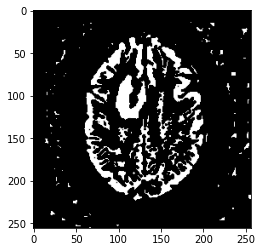

In [ ]:
cluster = 10

masked_image = np.copy(image)
masked_image = masked_image.reshape((-1,3))
extracted = np.copy(masked_image)
masked_image[labels == cluster] = [0,0,0]
extracted[labels != cluster] = [0,0,0]
masked_image = masked_image.reshape(image.shape)
extracted = extracted.reshape(image.shape)
image = extracted
# show the image
plt.figure
plt.imshow(image)
plt.show()

## Morphological operation

In [ ]:
#kernel = np.ones((3,3), np.uint8)
eroded = cv2.erode(image, None, iterations=1) 
dilated = cv2.dilate(eroded, None, iterations=1) 
cv2_imshow(eroded)
cv2_imshow(dilated)

## Tumor contouring

In [ ]:
#connected component analysis
gray = cv2.cvtColor(dilated, cv2.COLOR_BGR2GRAY)

thresh = cv2.threshold(gray, 0, 255,	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
#thresh = cv2.adaptiveThreshold(gray, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15,0)
connectivity = 8 
output = cv2.connectedComponentsWithStats(
	thresh, connectivity, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

In [ ]:
mask = np.zeros(gray.shape, dtype="uint8")

#looping over unique labels
x = np.zeros(numLabels)
y = np.zeros(numLabels)
h = np.zeros(numLabels)
w = np.zeros(numLabels)
area = np.zeros(numLabels)

for i in range(1, numLabels): #id 0  background
	# extract the connected component statistics for the current
	# label
	x[i] = stats[i, cv2.CC_STAT_LEFT]
	y[i] = stats[i, cv2.CC_STAT_TOP]
	w[i] = stats[i, cv2.CC_STAT_WIDTH]
	h[i] = stats[i, cv2.CC_STAT_HEIGHT]
	area[i] = stats[i, cv2.CC_STAT_AREA]

In [ ]:
components =np.zeros(((numLabels,image.shape[0],image.shape[1])),dtype = np.uint8)
index = []
for i in range(1,numLabels):
  keepWidth = w[i]>0
  keepHeight = h[i]>0
  keepArea = area[i]>0
  if all((keepWidth,keepHeight,keepArea)):
    componentMask = (labels == i).astype('uint8')*255
    mask = cv2.bitwise_or(mask,componentMask)
    components[i,:,:] = mask
    index.append(i)

In [ ]:
#extracting tumor by subtractiong between two connected component analyzed images
for i in range(len(index)):
  plt.figure(i)
  print(index[i])
  cv2_imshow(components[index[i],:,:])
  cv2.waitKey(0)

In [ ]:
first_tumor = 16
tumor = components[first_tumor,:,:] - components[first_tumor-1,:,:]
cv2_imshow(tumor)

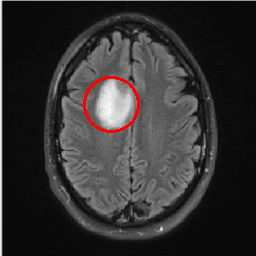

In [ ]:
#loading image again
img = cv2.imread(img_file)
dim = (256,256)
image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)


# find contours in thresholded image, then grab the largest one
import imutils
cnts = cv2.findContours(tumor.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# determine the most extreme points along the contour
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

#finding out centroid
points = [list(extLeft),list(extRight),list(extTop),list(extBot)]
x = [p[0] for p in points]
y = [p[1] for p in points]
centroid = (sum(x) / len(points), sum(y) / len(points))

#radius
import numpy as np
dist = 0 
for i in range(len(x)):
  dist_ = np.sqrt((centroid[0]-x[i])**2 + (centroid[1]-y[i])**2)
  if dist_>dist:
    dist = dist_
radius = int(np.floor(dist))

center = (int(np.floor(centroid[0])),int(np.floor(centroid[1])))

#drawing circular contour
demo2 = image.copy()
a = cv2.circle(demo2, center, radius, (0, 0, 255), 2)
cv2_imshow(demo2)

# Preparing data for Feature Extraction

## preparing the dataset folders(only once)

take all the yes and no images into separate folders and extract features from them

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#counting files
import os,glob,shutil

os.chdir('/content/drive/MyDrive/Dataset_2/dataset/no/')
count = 0
for f in glob.glob("*"):
  count += 1

print(count)

98


In [ ]:
#no need to run

count = 0
dirpath = '/content/drive/MyDrive/Dataset_2/dataset/no/'

dim = (256,256)

os.chdir(dirpath)
filenames = os.listdir(dirpath)

dest_dir = '/content/drive/MyDrive/Dataset_2/ML_datasets/all_contour_no/256x256/'

for fname in filenames:
  img = cv2.imread(fname)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  dest = dest_dir + fname
  cv2.imwrite(dest,img)
  print(count)
  count += 1

## creating csv files with all features


In [ ]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from google.colab.patches import cv2_imshow
%matplotlib inline

from scipy.stats import skew
import scipy.stats as stats

from scipy.stats import kurtosis

import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data

import cv2
from google.colab.patches import cv2_imshow

In [ ]:
#load a file using opencv and give it as input in the following functions

from scipy.stats import skew
import scipy.stats as stats

from scipy.stats import kurtosis

def stat_features(mean,variance,std,skewness,img):
  im = img.flatten()

  m = np.mean(im)
  v = np.var(im)
  st = np.std(im)
  sk = np.absolute(skew(im))

  mean.append(m)
  variance.append(v)
  std.append(st)
  skewness.append(sk)

In [ ]:
#glcm features

def glcm_features(dissimilarity,correlation,asm,energy,homogeneity,contrast,gray_img):
  glcm = greycomatrix(gray_img, [5], [0], 256, symmetric=True, normed=True)

  dis = greycoprops(glcm, 'dissimilarity')[0, 0]
  corr = greycoprops(glcm, 'correlation')[0, 0]
  a = greycoprops(glcm, 'ASM')[0, 0]
  en = greycoprops(glcm, 'energy')[0, 0]
  hom = greycoprops(glcm, 'homogeneity')[0, 0]
  cont = greycoprops(glcm, 'contrast')[0, 0]

  dissimilarity.append(dis)
  correlation.append(corr)
  asm.append(a)
  energy.append(en)
  homogeneity.append(hom)
  contrast.append(cont)

In [ ]:
def coarseness(image, kmax):
	image = np.array(image)
	w = image.shape[0]
	h = image.shape[1]
	kmax = kmax if (np.power(2,kmax) < w) else int(np.log(w) / np.log(2))
	kmax = kmax if (np.power(2,kmax) < h) else int(np.log(h) / np.log(2))
	average_gray = np.zeros([kmax,w,h])
	horizon = np.zeros([kmax,w,h])
	vertical = np.zeros([kmax,w,h])
	Sbest = np.zeros([w,h])

	for k in range(kmax):
		window = np.power(2,k)
		for wi in range(w)[window:(w-window)]:
			for hi in range(h)[window:(h-window)]:
				average_gray[k][wi][hi] = np.sum(image[wi-window:wi+window, hi-window:hi+window])
		for wi in range(w)[window:(w-window-1)]:
			for hi in range(h)[window:(h-window-1)]:
				horizon[k][wi][hi] = average_gray[k][wi+window][hi] - average_gray[k][wi-window][hi]
				vertical[k][wi][hi] = average_gray[k][wi][hi+window] - average_gray[k][wi][hi-window]
		horizon[k] = horizon[k] * (1.0 / np.power(2, 2*(k+1)))
		vertical[k] = horizon[k] * (1.0 / np.power(2, 2*(k+1)))

	for wi in range(w):
		for hi in range(h):
			h_max = np.max(horizon[:,wi,hi])
			h_max_index = np.argmax(horizon[:,wi,hi])
			v_max = np.max(vertical[:,wi,hi])
			v_max_index = np.argmax(vertical[:,wi,hi])
			index = h_max_index if (h_max > v_max) else v_max_index
			Sbest[wi][hi] = np.power(2,index)

	fcrs = np.mean(Sbest)
	return fcrs

In [ ]:
def directionality(image):
	image = np.array(image, dtype = 'int64')
	h = image.shape[0]
	w = image.shape[1]
	convH = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
	convV = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
	deltaH = np.zeros([h,w])
	deltaV = np.zeros([h,w])
	theta = np.zeros([h,w])

	# calc for deltaH
	for hi in range(h)[1:h-1]:
		for wi in range(w)[1:w-1]:
			deltaH[hi][wi] = np.sum(np.multiply(image[hi-1:hi+2, wi-1:wi+2], convH))
	for wi in range(w)[1:w-1]:
		deltaH[0][wi] = image[0][wi+1] - image[0][wi]
		deltaH[h-1][wi] = image[h-1][wi+1] - image[h-1][wi]
	for hi in range(h):
		deltaH[hi][0] = image[hi][1] - image[hi][0]
		deltaH[hi][w-1] = image[hi][w-1] - image[hi][w-2]

	# calc for deltaV
	for hi in range(h)[1:h-1]:
		for wi in range(w)[1:w-1]:
			deltaV[hi][wi] = np.sum(np.multiply(image[hi-1:hi+2, wi-1:wi+2], convV))
	for wi in range(w):
		deltaV[0][wi] = image[1][wi] - image[0][wi]
		deltaV[h-1][wi] = image[h-1][wi] - image[h-2][wi]
	for hi in range(h)[1:h-1]:
		deltaV[hi][0] = image[hi+1][0] - image[hi][0]
		deltaV[hi][w-1] = image[hi+1][w-1] - image[hi][w-1]

	deltaG = (np.absolute(deltaH) + np.absolute(deltaV)) / 2.0
	deltaG_vec = np.reshape(deltaG, (deltaG.shape[0] * deltaG.shape[1]))

	# calc the theta
	for hi in range(h):
		for wi in range(w):
			if (deltaH[hi][wi] == 0 and deltaV[hi][wi] == 0):
				theta[hi][wi] = 0;
			elif(deltaH[hi][wi] == 0):
				theta[hi][wi] = np.pi
			else:
				theta[hi][wi] = np.arctan(deltaV[hi][wi] / deltaH[hi][wi]) + np.pi / 2.0
	theta_vec = np.reshape(theta, (theta.shape[0] * theta.shape[1]))

	n = 16
	t = 12
	cnt = 0
	hd = np.zeros(n)
	dlen = deltaG_vec.shape[0]
	for ni in range(n):
		for k in range(dlen):
			if((deltaG_vec[k] >= t) and (theta_vec[k] >= (2*ni-1) * np.pi / (2 * n)) and (theta_vec[k] < (2*ni+1) * np.pi / (2 * n))):
				hd[ni] += 1
	hd = hd / np.mean(hd)
	hd_max_index = np.argmax(hd)
	fdir = 0
	for ni in range(n):
		fdir += np.power((ni - hd_max_index), 2) * hd[ni]
	return fdir

In [ ]:
def roughness(fcrs, fcon):
	return fcrs + fcon

In [ ]:
#creating list for all of the features
import os,glob
count = 0
dirpath = '/content/drive/MyDrive/Dataset_2/ML_datasets/all_contour_yes/224x224/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

dissimilarity = []
correlation = []
asm = []
energy = []
homogeneity = []
contrast = []

mean = []
std = []
skewness = []
variance = []

fcrs = []
fr = []
fdir = []

image_title = []
image_label = []


for fname in filenames:
  image_title.append(fname)
  image_label.append(1)

  
  img = cv2.imread(fname)
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


  stat_features(mean,variance,std,skewness,img)
  glcm_features(dissimilarity,correlation,asm,energy,homogeneity,contrast,gray_img)

  fcrs.append(coarseness(gray_img, 5))
  fr.append(roughness(fcrs[count], contrast[count]))
  fdir.append(directionality(gray_img))

  print(count)
  count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154


In [ ]:
dirpath = '/content/drive/MyDrive/Dataset_2/ML_datasets/all_contour_no/224x224/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  image_title.append(fname)
  image_label.append(0)


  img = cv2.imread(fname)
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


  stat_features(mean,variance,std,skewness,img)
  glcm_features(dissimilarity,correlation,asm,energy,homogeneity,contrast,gray_img)

  fcrs.append(coarseness(gray_img, 5))
  fr.append(roughness(fcrs[count], contrast[count]))
  fdir.append(directionality(gray_img))

  print(count)
  count += 1

155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252


In [ ]:
#for identifying negative values in features
#the training won't work for negative values
(np.array(skewness) < 0).any()

False

In [ ]:
# Import packages
import numpy as np
import pandas as pd# Update default settings to show 2 decimal place
pd.options.display.float_format = '{:.2f}'.format# Create a small dataframe
df = pd.DataFrame({'Image': image_title,
                   'Class': image_label,
                   'Mean': mean,
                   'Standard Deviation': std,
                   'Variance': variance,
                   'Skewness': skewness,
                   'Contrast': contrast,
                   'Homogeneity': homogeneity,
                   'Energy': energy,
                   'ASM': asm,
                   'Correlation': correlation,
                   'Dissimilarity': dissimilarity,
                   #'Roughness': fr,
                   #'coarseness': fcrs,
                   'Directionality':fdir ,
                   })
df

,Image,Class,Mean,Standard Deviation,Variance,Skewness,Contrast,Homogeneity,Energy,ASM,Correlation,Dissimilarity,Directionality
0,Y62.png,1,37.97,41.86,1752.62,1.33,1181.18,0.29,0.10,0.01,0.63,16.36,287.28
1,Y64.png,1,63.39,62.66,3926.04,0.58,2007.88,0.33,0.28,0.08,0.73,23.33,331.88
2,Y68.png,1,44.65,40.41,1632.79,0.87,793.93,0.21,0.07,0.01,0.73,14.46,300.52
3,Y71.png,1,67.60,55.19,3046.11,0.75,1215.17,0.24,0.11,0.01,0.79,18.68,342.26
4,Y73.png,1,45.56,56.16,3154.18,1.53,1124.57,0.31,0.24,0.06,0.82,18.12,391.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,21 no.jpg,0,48.05,56.53,3195.70,1.42,1428.90,0.38,0.21,0.04,0.78,19.57,300.72
249,no 1.jpg,0,29.74,35.44,1256.32,1.17,943.45,0.37,0.20,0.04,0.63,14.93,307.34
250,46 no.jpg,0,56.21,66.73,4453.45,0.68,1355.42,0.48,0.44,0.19,0.85,18.06,1155.65
251,no 89.jpg,0,36.87,37.80,1429.12,0.54,474.82,0.31,0.13,0.02,0.83,10.48,285.73


In [ ]:
df.head()

,Image,Class,Mean,Standard Deviation,Variance,Skewness,Contrast,Homogeneity,Energy,ASM,Correlation,Dissimilarity,Directionality
0,Y62.png,1,37.97,41.86,1752.62,1.33,1181.18,0.29,0.10,0.01,0.63,16.36,287.28
1,Y64.png,1,63.39,62.66,3926.04,0.58,2007.88,0.33,0.28,0.08,0.73,23.33,331.88
2,Y68.png,1,44.65,40.41,1632.79,0.87,793.93,0.21,0.07,0.01,0.73,14.46,300.52
3,Y71.png,1,67.60,55.19,3046.11,0.75,1215.17,0.24,0.11,0.01,0.79,18.68,342.26
4,Y73.png,1,45.56,56.16,3154.18,1.53,1124.57,0.31,0.24,0.06,0.82,18.12,391.87


In [ ]:
df.columns

Index(['Image', 'Class', 'Mean', 'Standard Deviation', 'Variance', 'Skewness',
       'Contrast', 'Homogeneity', 'Energy', 'ASM', 'Correlation',
       'Dissimilarity', 'Directionality'],
      dtype='object')

In [ ]:
# saving the dataframe
df.to_csv('/content/drive/MyDrive/Dataset_2/ML_datasets/feature_224x224.csv')